In [2]:
#Imports and dependencies
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from scipy.ndimage.morphology import binary_dilation
from itertools import product
from typing import List
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
import time
from copy import deepcopy

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.shapes import Sphere, SphericalSpiral
from utils.data import RenderManager, ImageManager

['/home/alexis/Desktop/E3D', '/home/alexis/Desktop/E3D', '/home/alexis/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/alexis/.ipython']


In [4]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

In [ ]:
#Download a couple meshes to work with
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

### Load Object

In [5]:
#Load the object without textures and materials
verts, faces_idx, _ = load_obj("data/meshes/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning:

Faces have invalid indices



### Create a renderer

In [7]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights)
)

### Create a reference image - look_at_view_transform

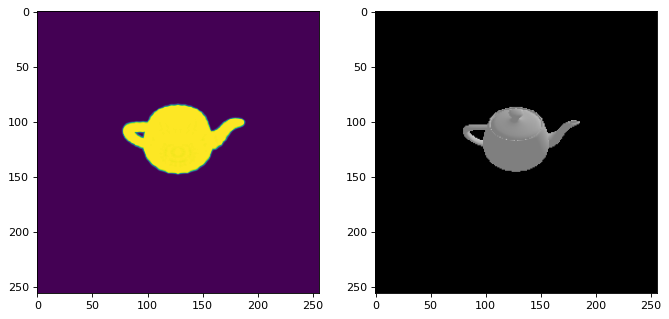

In [5]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Create a reference image - look_at_rotation

In [ ]:
# Position of the camera in world coordinates
x = 2.1
y = 3.4
z = 0.5
cam_posn = torch.from_numpy(np.array([x, y, z], dtype=np.float32))
#at - position of the object in world coordinates 
#up - vector of up direction in world coordinates
R = look_at_rotation(cam_posn[None, :], device=device)
T = -torch.bmm(R.transpose(1,2), cam_posn[None, :, None])[:, :, 0]

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

In [22]:
Sphere(
    radius=2,
    num_points_theta = 1,
    num_points_phi =20,
    theta_min = math.pi/2,
    theta_max = math.pi/2, 
    phi_max = math.pi).plot()

SphericalSpiral(
    c = 8,
    a = 2,
    t_min = math.pi,
    t_max=.005*math.pi,
    num_points=40).plot()


### Camera Pose Trajectory and render

silhouette
shaded


/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



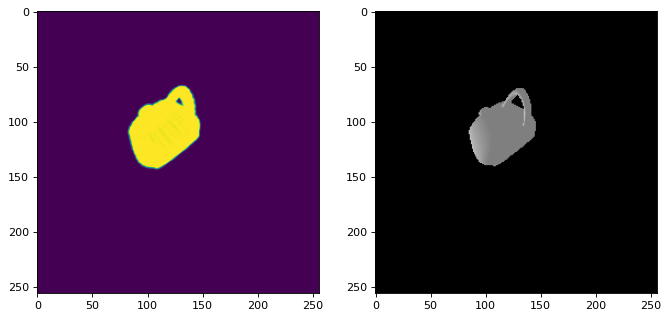

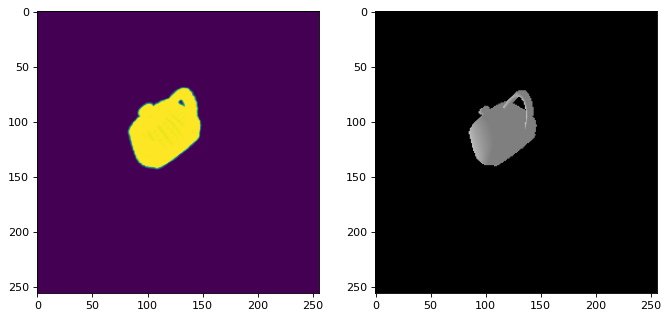

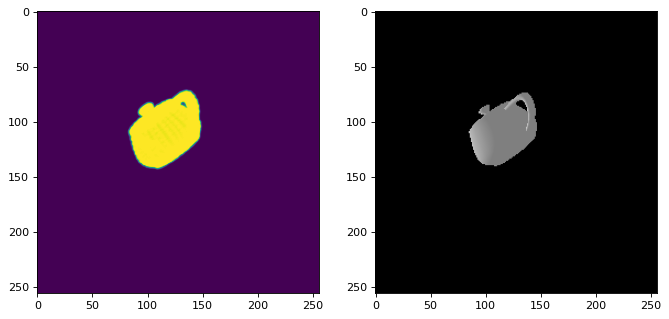

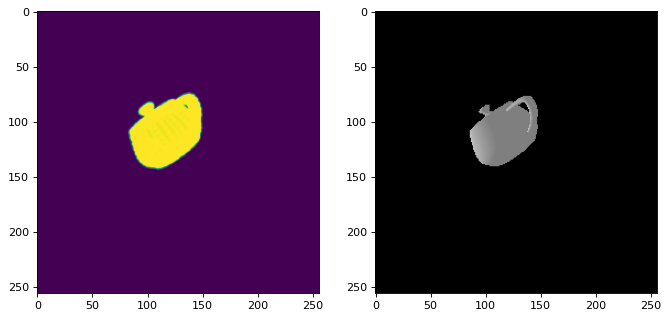

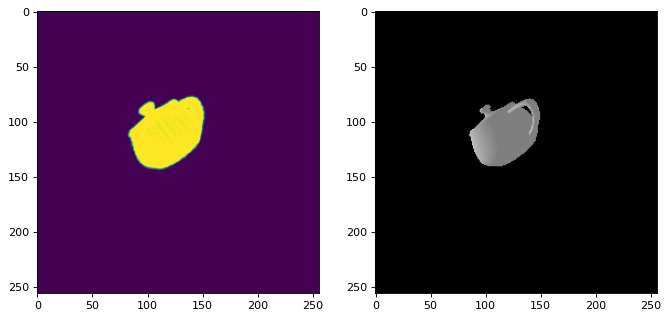

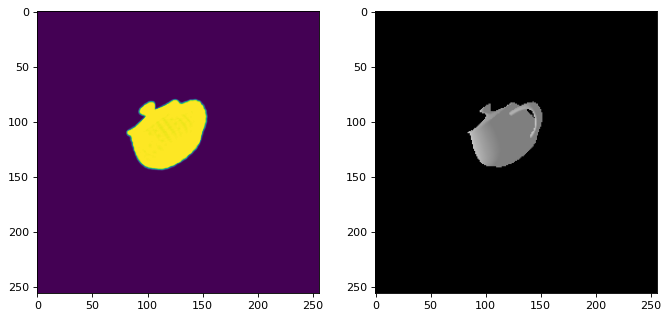

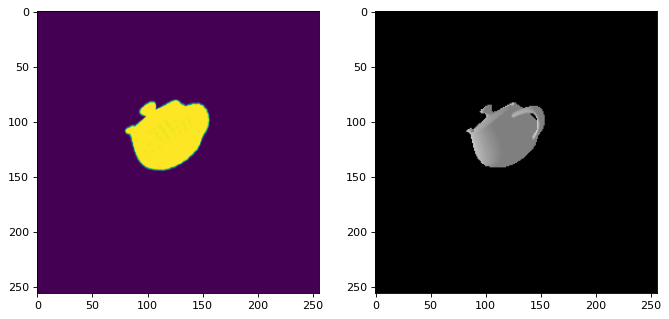

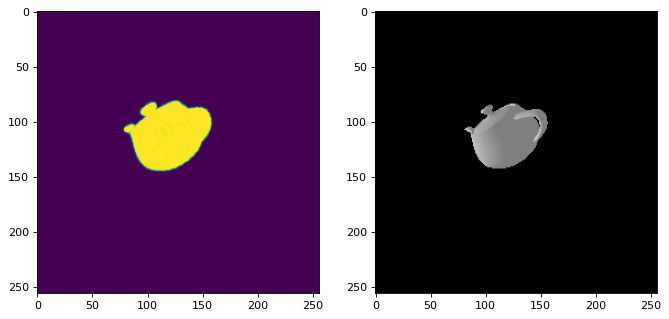

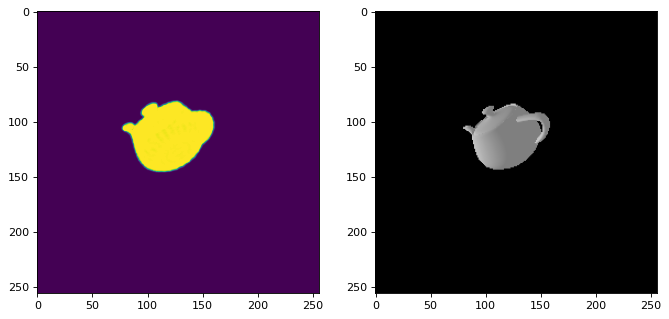

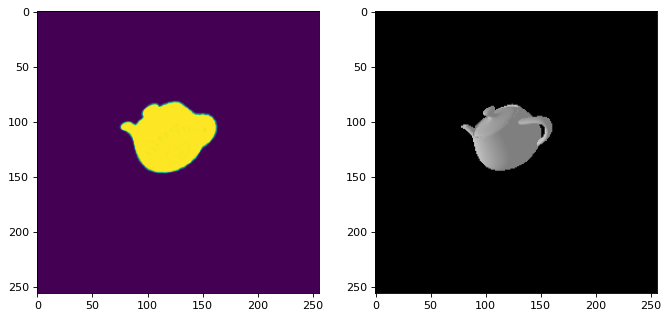

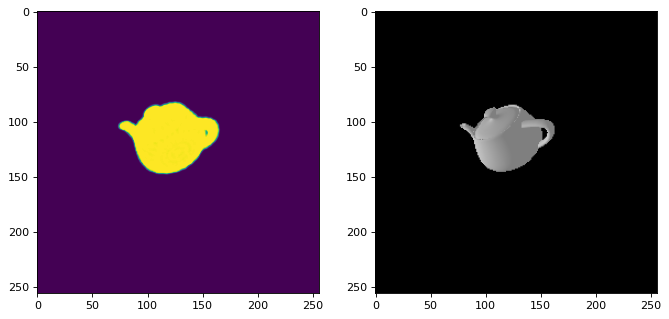

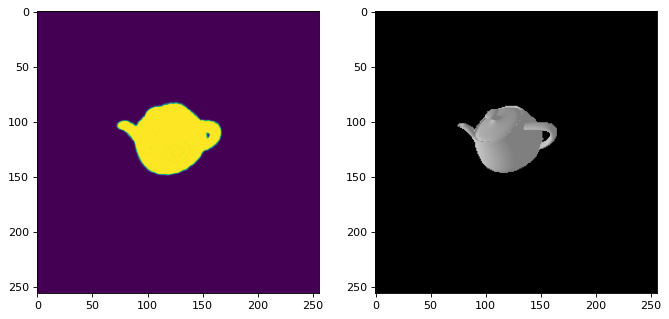

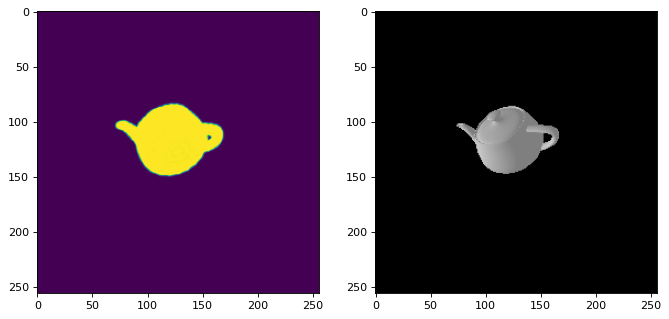

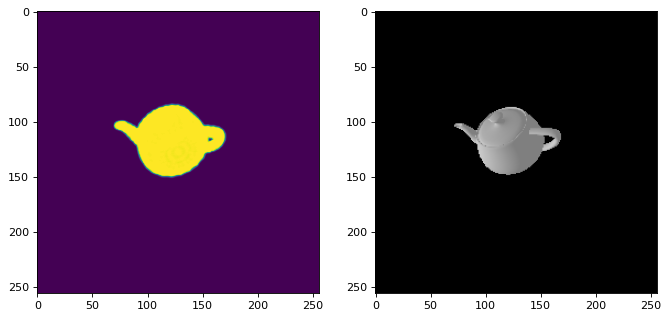

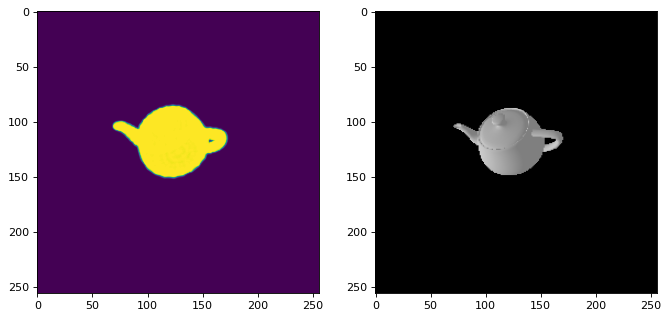

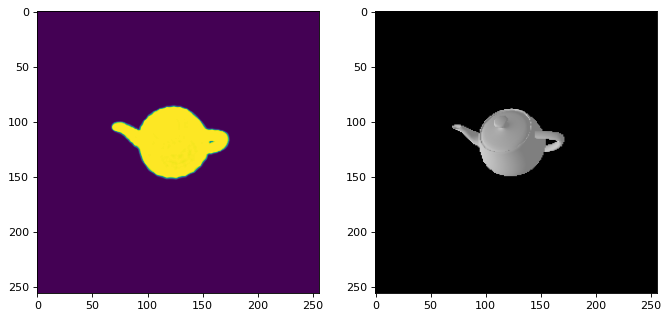

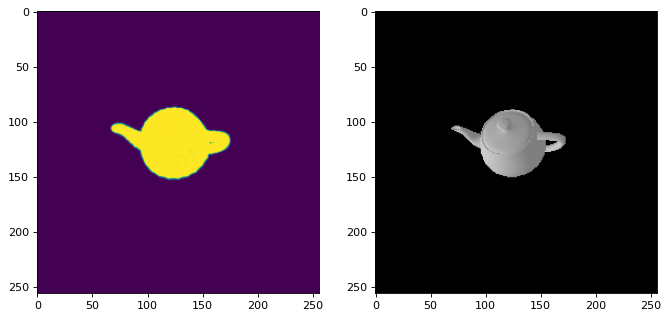

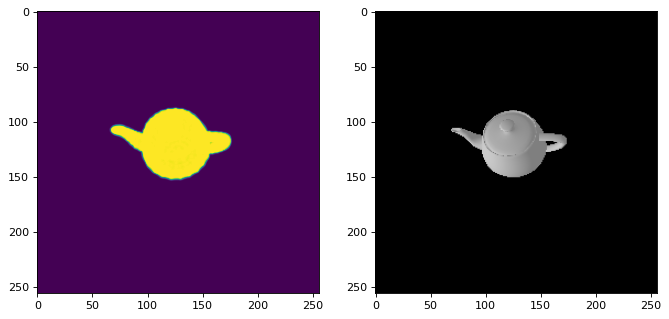

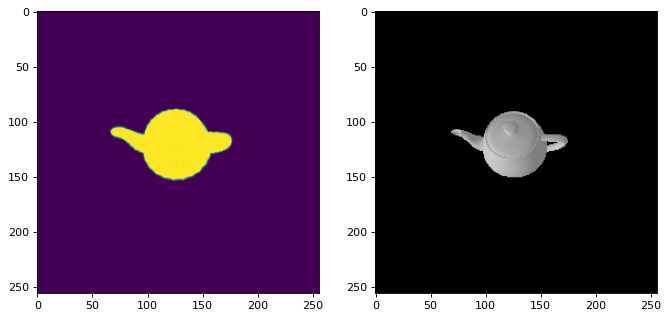

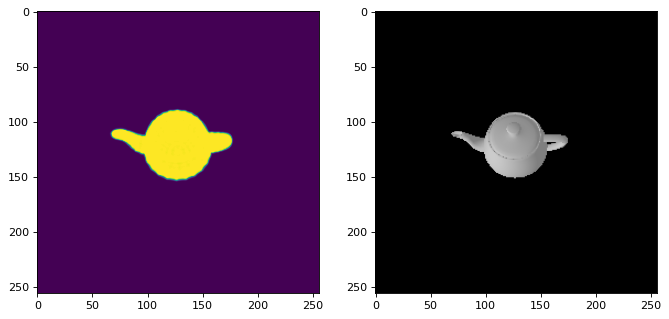

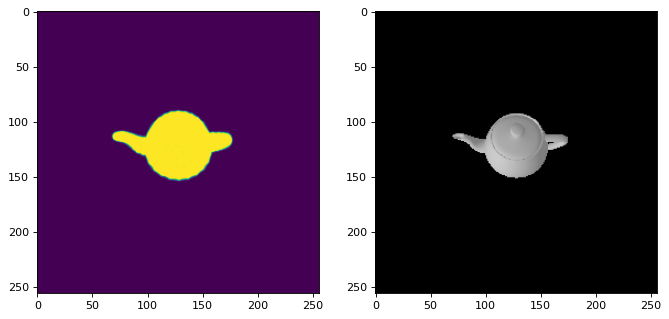

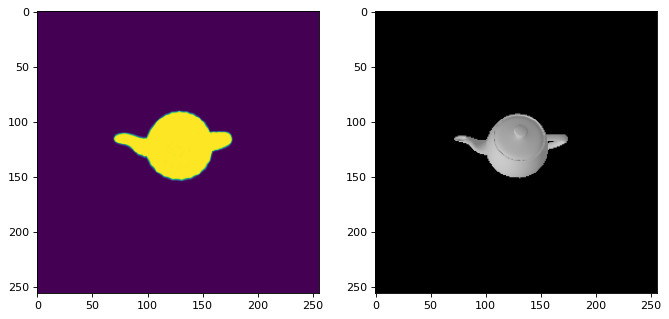

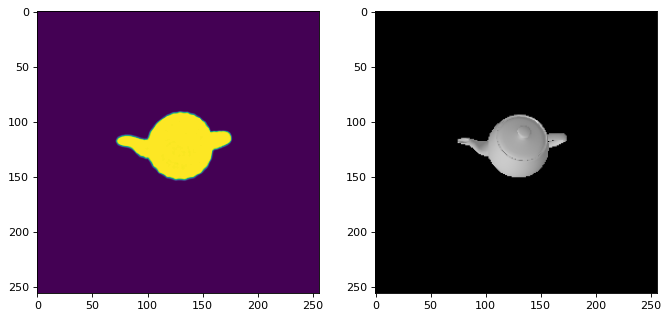

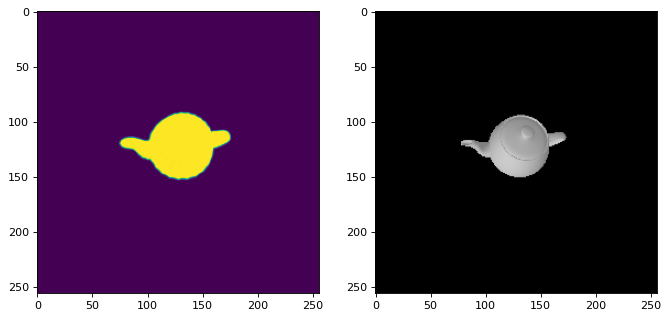

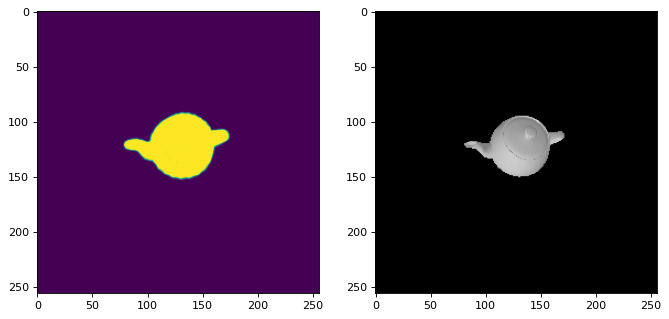

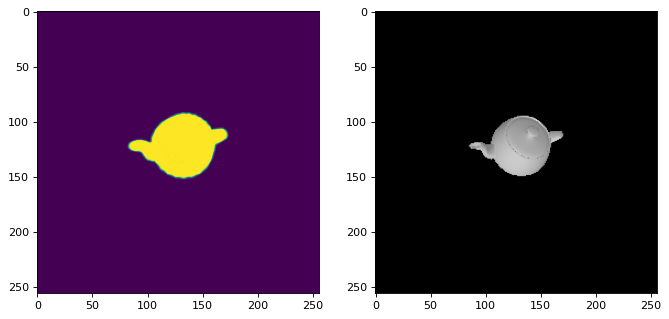

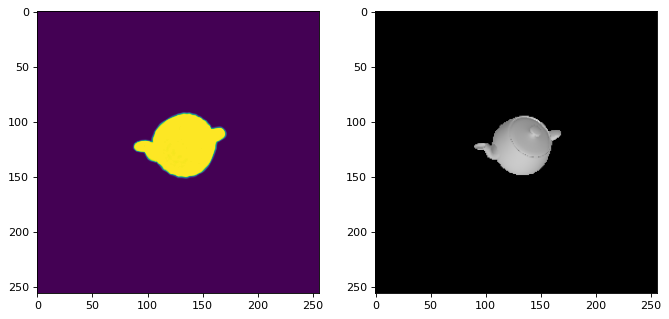

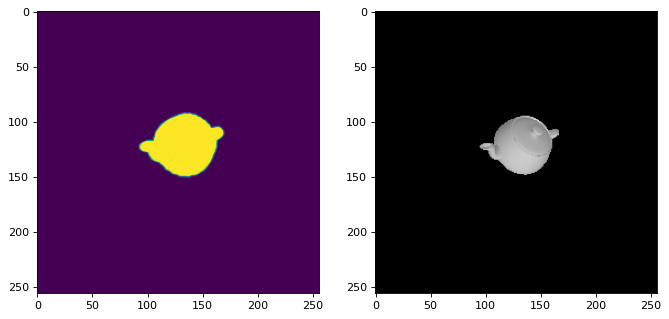

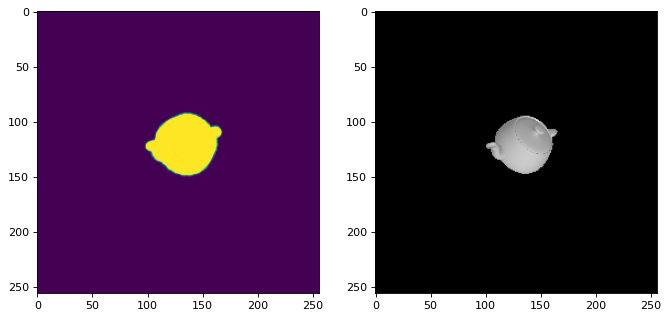

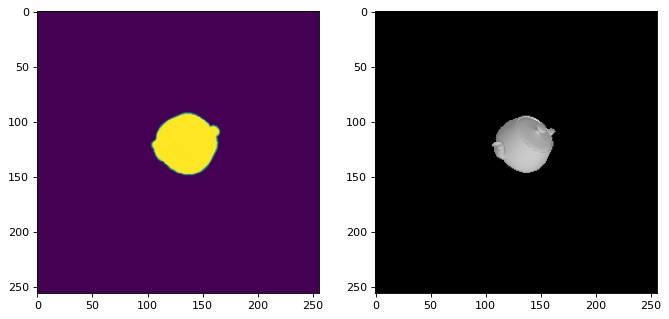

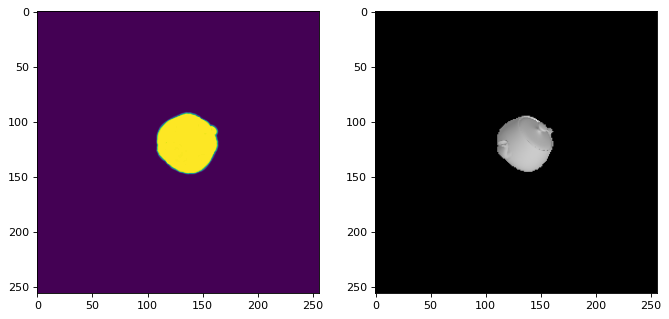

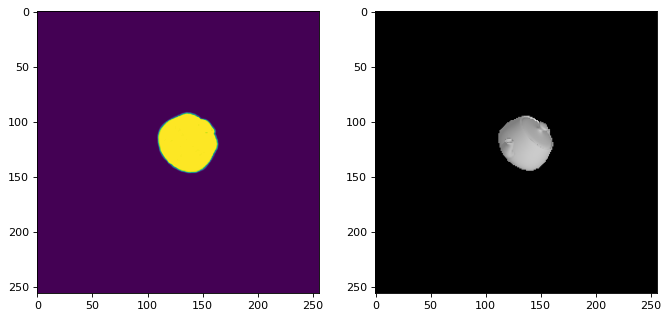

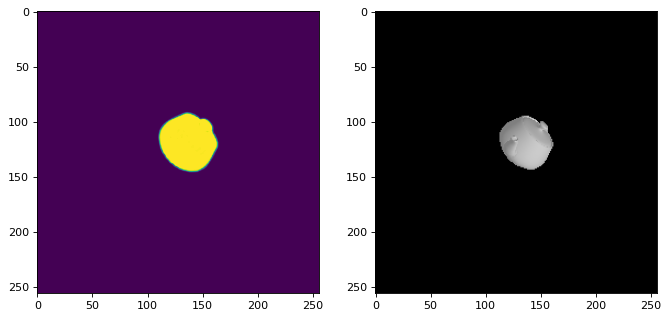

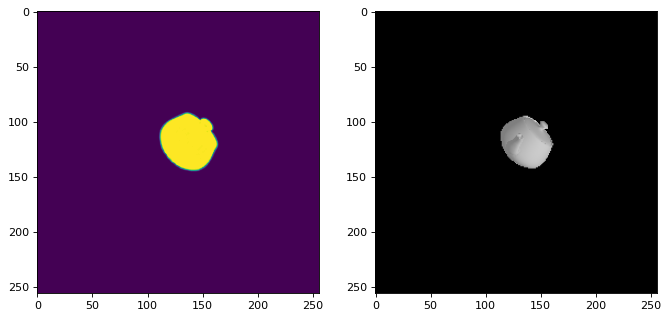

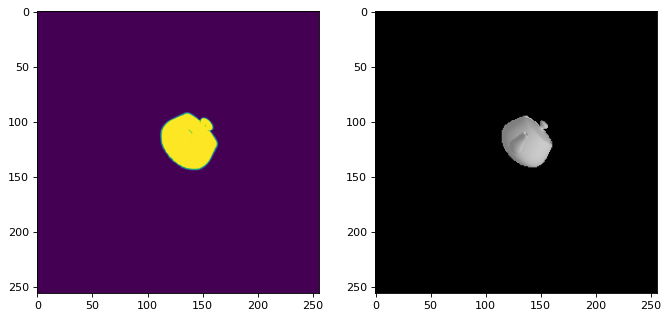

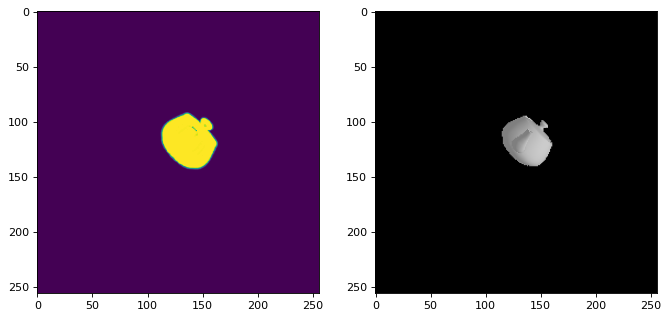

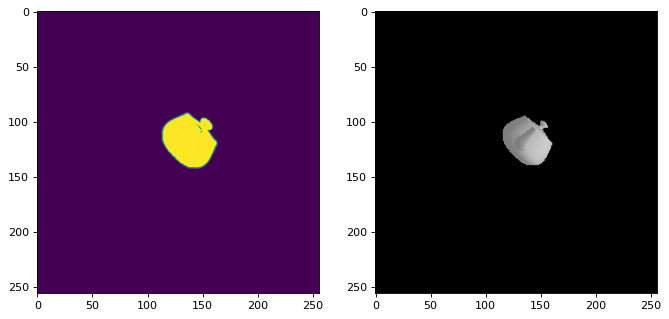

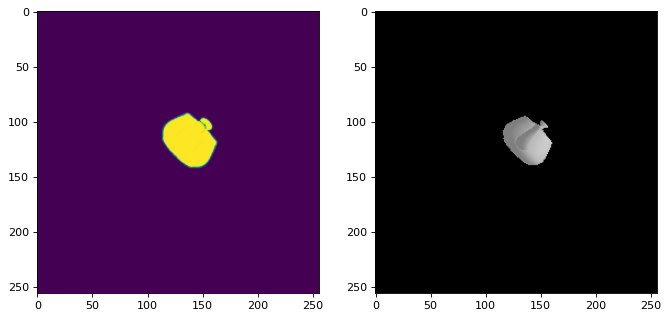

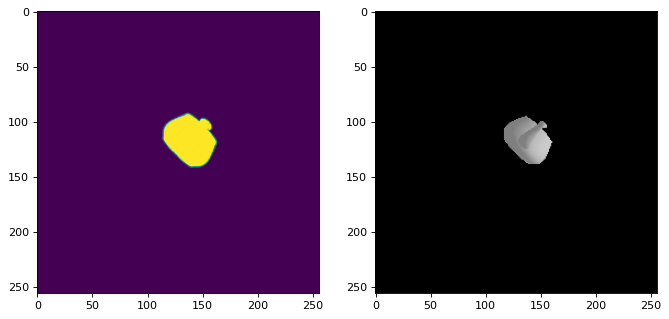

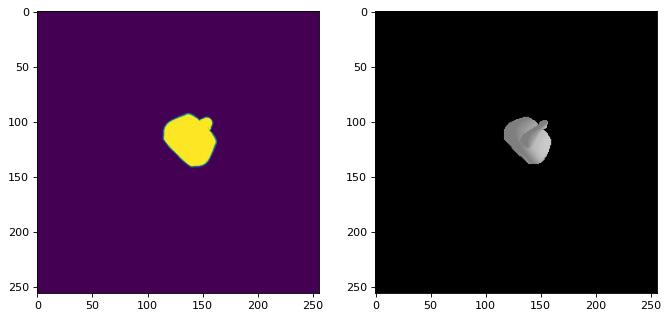

In [8]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

#Just to put these somewhere - this should be stored in param file after

def cam_trajectory_rotation():
    """
    Input: 
    Return cameras from trajectory along a sphere
    """
    
    #sphere = Sphere(
    #    radius=2,
    #    num_points_theta = 1,
    #    num_points_phi = 30,
    #    theta_min = math.pi/2,
    #    theta_max = math.pi/2, 
    #    phi_max = math.pi)
    shape = SphericalSpiral(
        c = 8,
        a = 2,
        t_min = math.pi,
        t_max=.005*math.pi,
        num_points=40)
    up = torch.tensor([[0., 1., 1.]])
    camera_poses = []
    for cp in shape._tuples:
        cp = torch.tensor(cp)
        R = look_at_rotation(cp[None, :],up=up, device=device)
        T = -torch.bmm(R.transpose(1,2), cp[None, :, None])[:, :, 0]
        camera_poses.append((R,T))
    return camera_poses

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [10, 50],
    azim_range: list= [-180, 180]):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.linspace(elev_range[0], elev_range[1], batch_size)
    azim = torch.linspace(elev_range[0], elev_range[1], batch_size)
    cam_poses = []
    for e, a in elev, azim:
        R, T = look_at_view_transform(dist=dist, elev=e, azim=a)
        cam_poses.append((R,T))
    return cam_poses
    
def render_trajectory(cam_poses, write_gif=True):
    
    """
    output_folder = "./data/renders/"
    
    silhouette_output = join(output_folder, "camera_simulation_silhouette.gif")
    silhouette_writer = imageio.get_writer(silhouette_output, mode="I", duration=.2)
    
    image_output = join(output_folder, "camera_simulation_image.gif")
    image_writer = imageio.get_writer(image_output, mode="I", duration=.2)
    """
    render_manager = RenderManager(
        types=["silhouette", "shaded"],
        mesh_name = "teapot"
    )
    # Render the teapot providing the values of R and T.
    for num, (R,T) in enumerate(cam_poses):
        
        #gl_cam = OpenGLPerspectiveCameras(device=device, R=R, T=T)
        #sf_cam = SfMPerspectiveCameras(device=device, R=R, T=T)
        
        silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
        image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)
        
        silhouette = silhouette.cpu().numpy()
        image_ref = image_ref.cpu().numpy()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(silhouette.squeeze()[...,3])  # only plot the alpha channel of the RGBA image
        plt.grid(False)
        plt.subplot(1, 2, 2)
        plt.imshow(image_ref.squeeze())
        plt.grid(False)
        
        render_manager.add_images(
            num,
            {"silhouette": silhouette.squeeze()[...,3], "shaded": image_ref.squeeze()}, 
            R, T)
        
    
    render_manager.close()
    return render_manager
    
cam_poses = cam_trajectory_rotation()
render = render_trajectory(cam_poses)

# Generate events from consecutive frames

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



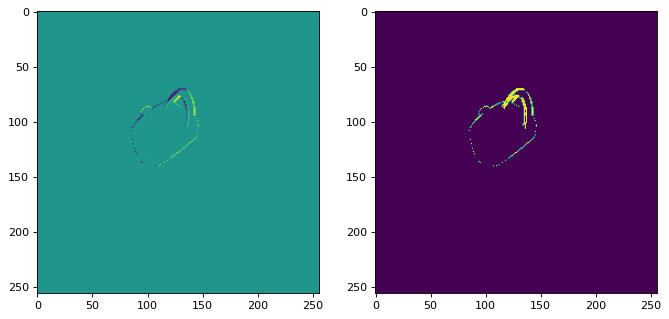

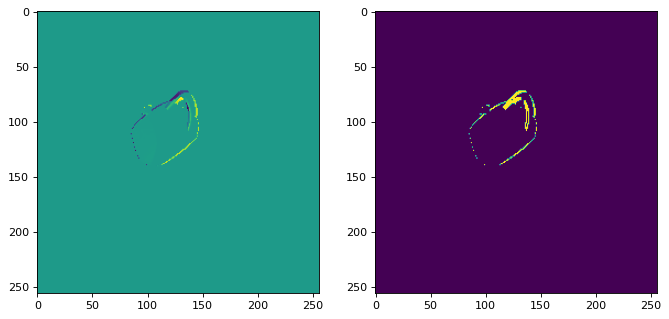

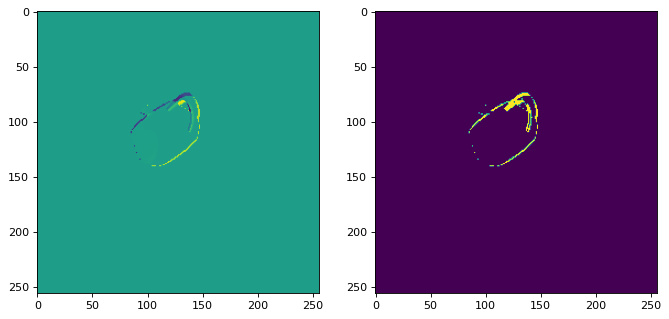

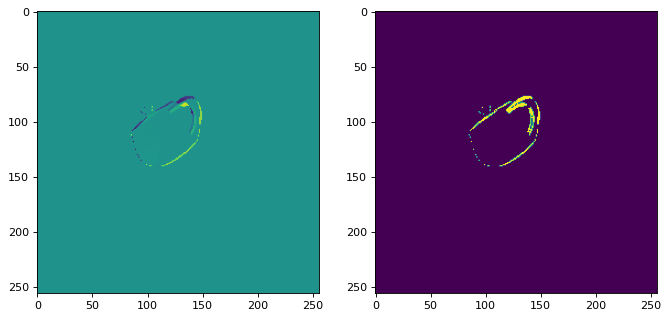

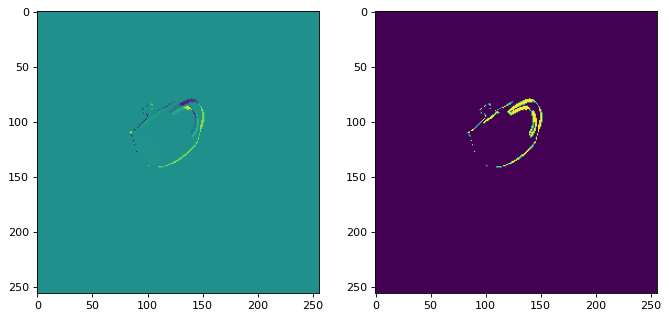

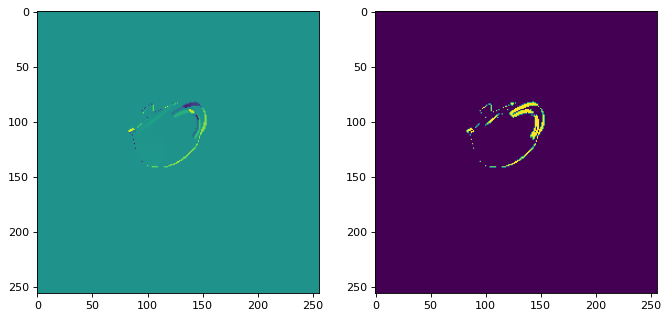

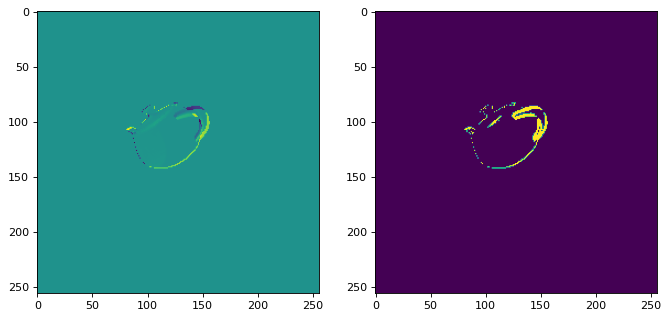

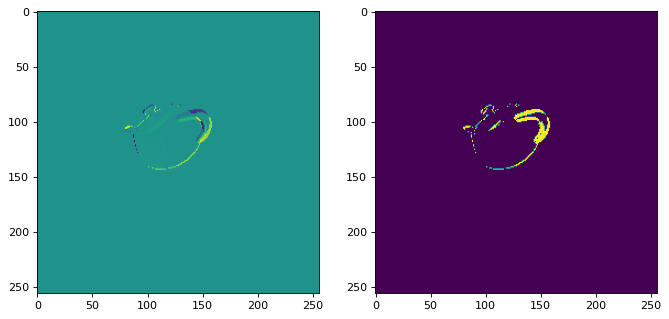

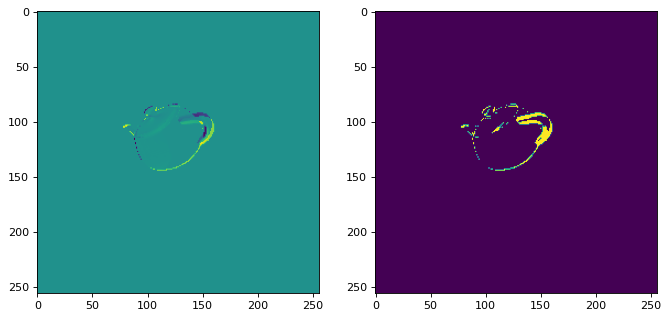

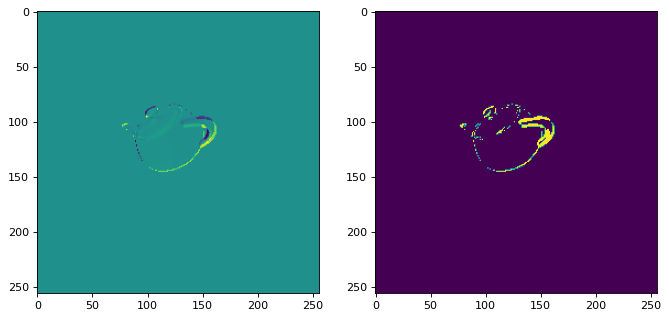

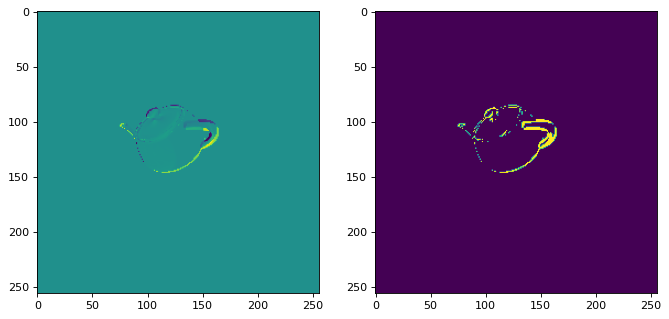

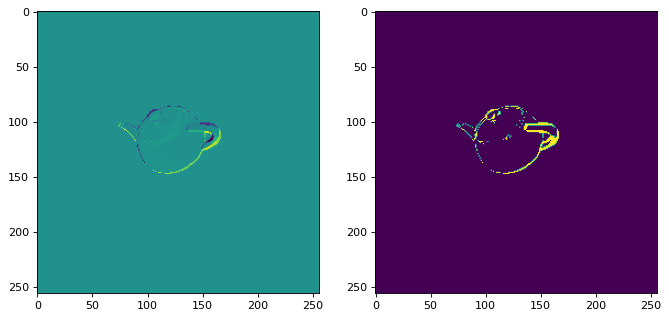

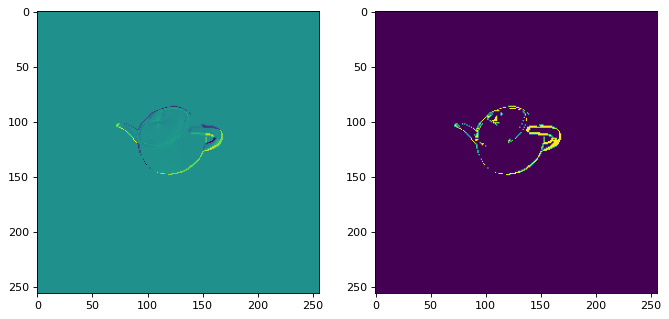

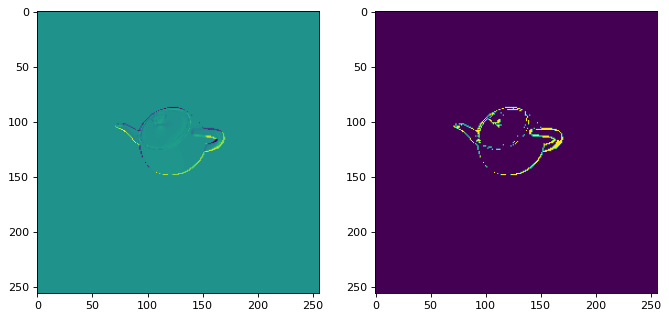

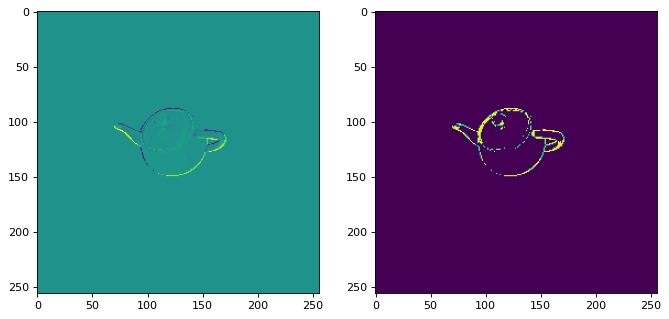

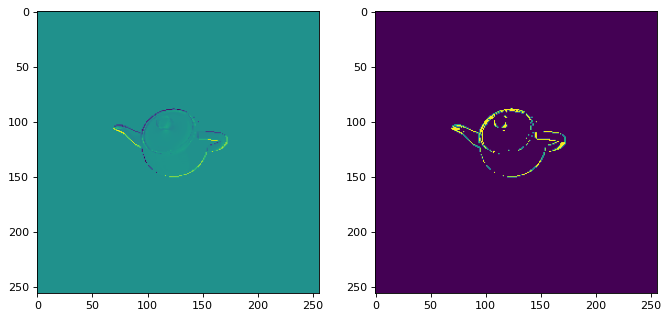

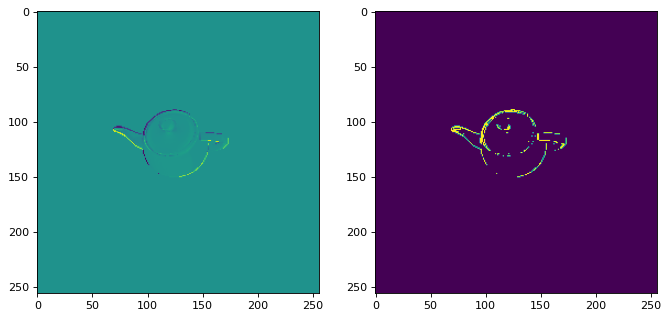

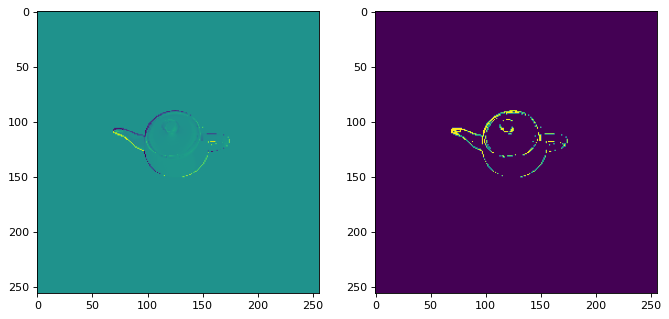

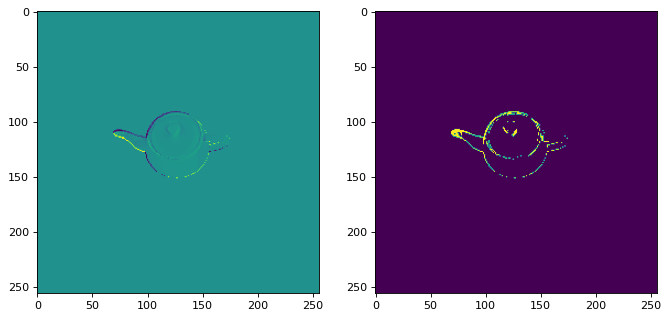

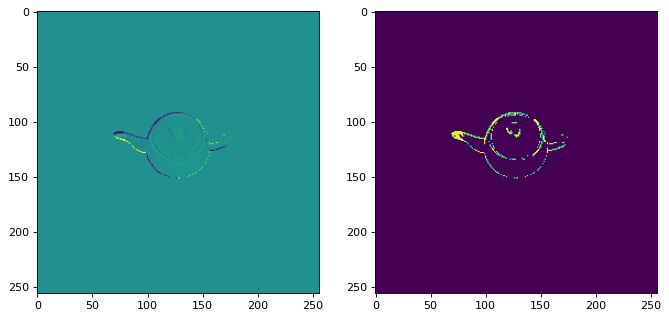

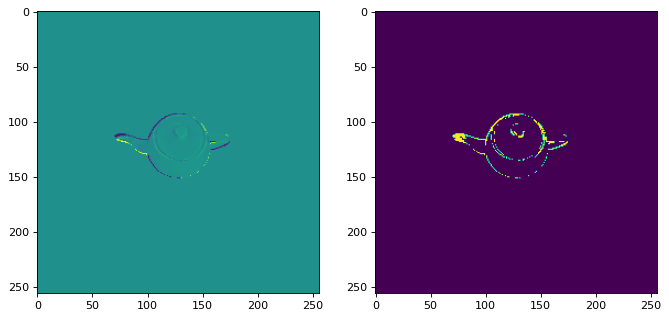

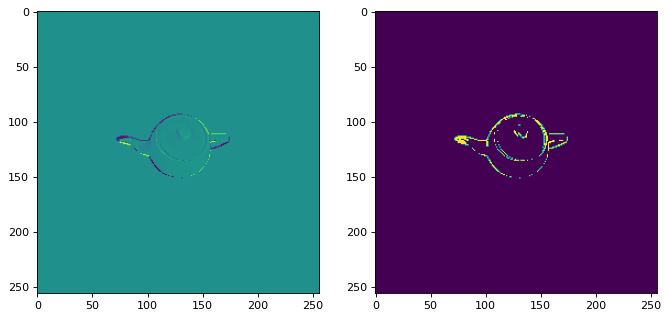

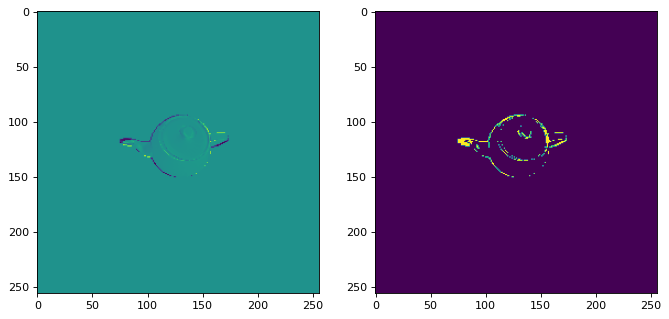

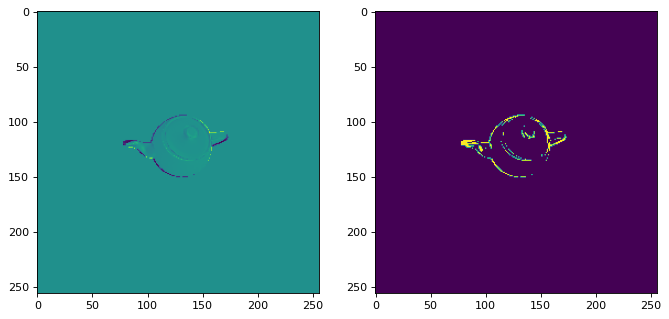

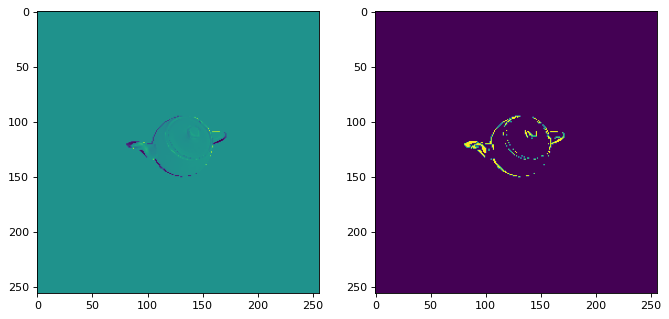

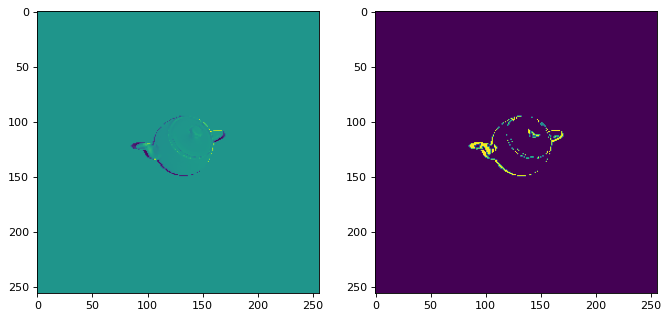

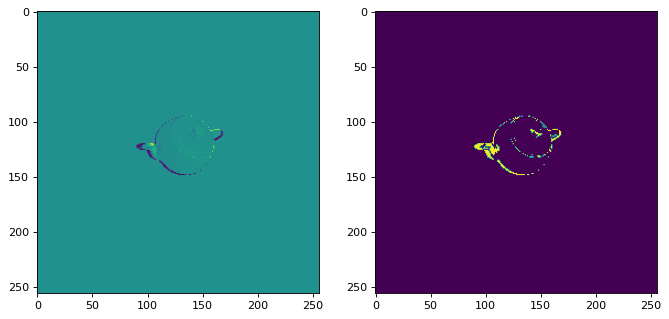

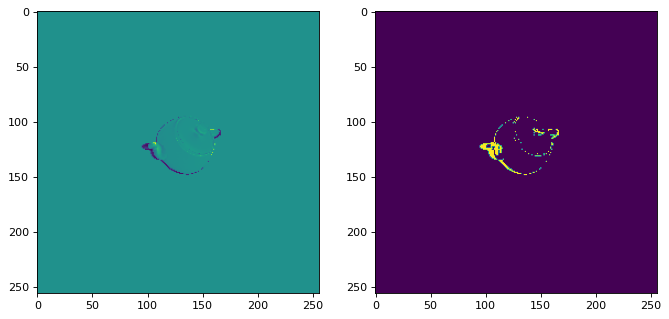

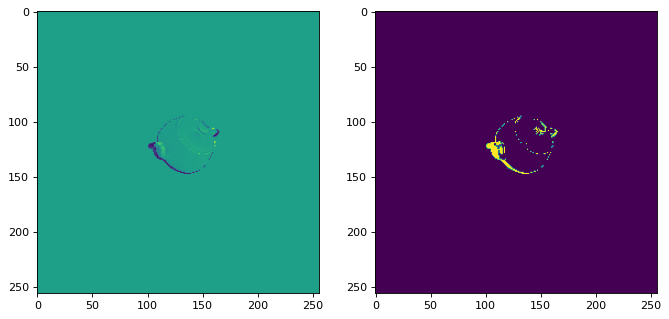

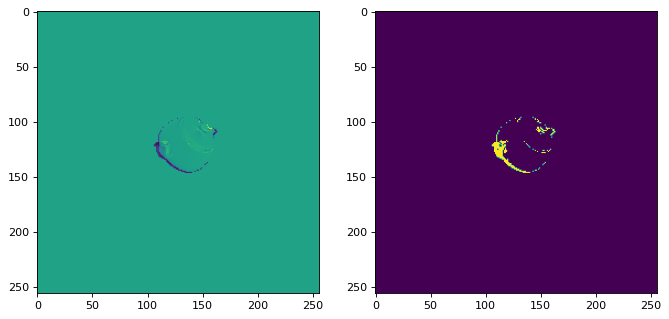

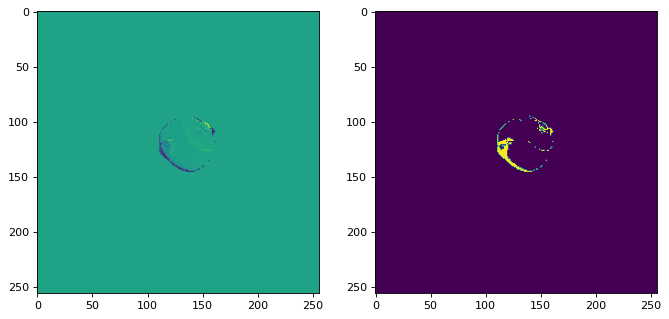

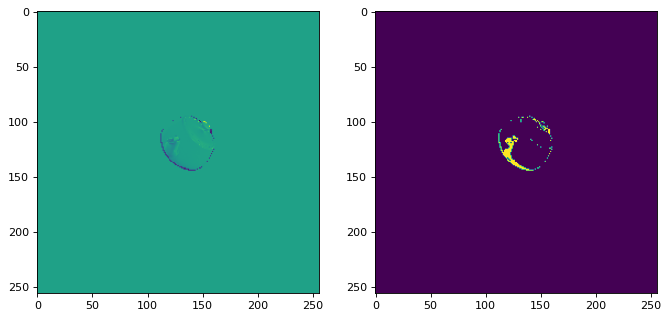

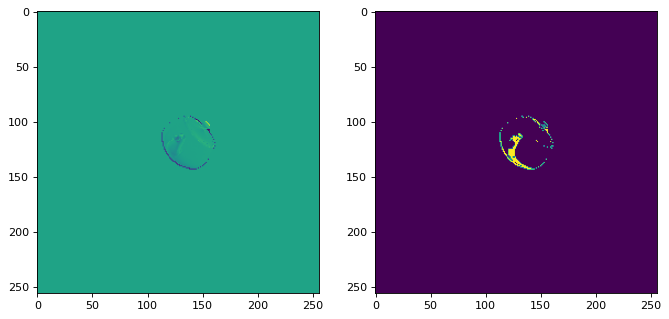

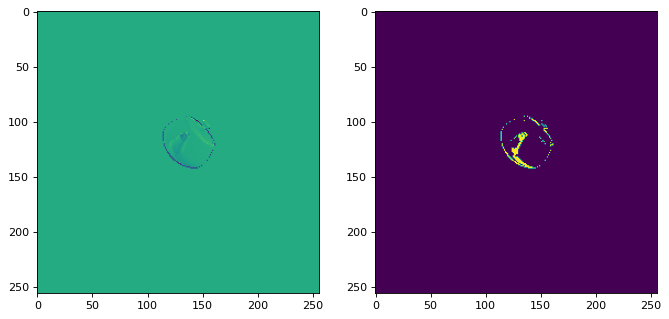

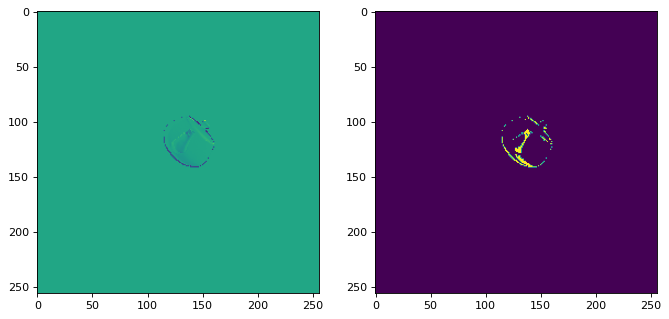

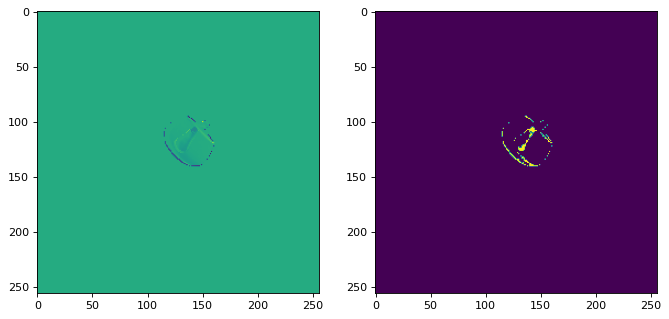

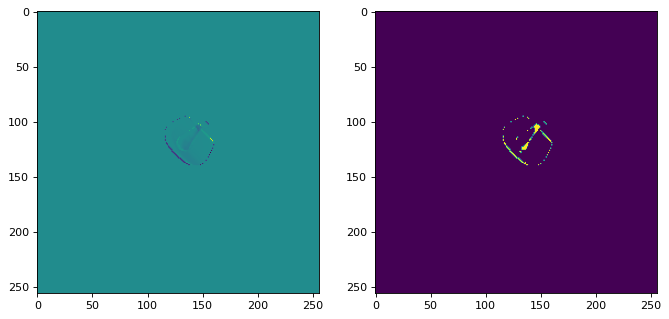

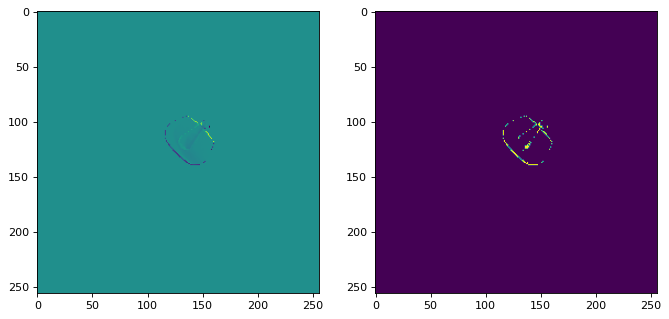

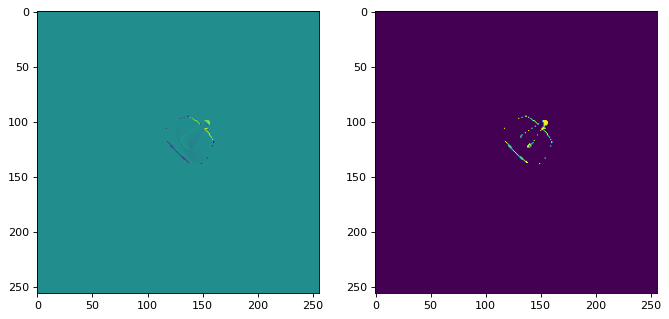

In [19]:
ON = 255
OFF = 0
threshold = 250

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def adaptive_thresholding(diff_frames):
    """
    Experiment: 
        Determine threshold from mean background illumination
    """
    raise NotImplementedError

def dilate_boundaries(diff_frame):
    """
    Experiment:
        Dilate the boundaries to introduce more noise on the outside
    """
    raise NotImplementedError

def fiter_consts(array_frame):
    const_filter = [float("nan"), float("inf")] #Just so we can extend this maybe?
    for const in const_filter:
        rows, cols = np.where(array_frame == const)
    

for type_key in render.images.keys():
    prev_img = None
    for num, img in enumerate(render.images[type_key]):
        img = deepcopy(img)
        img_manager = ImageManager.from_dict(img)        
        img_data = img_manager._load
        if type_key == "shaded":
                img_data = rgb2gray(img_data)
        else: continue
        if prev_img is not None:
            
            #if type_key == "shaded": print(np.where(img_data!=prev_img))
            
            
            diff_frames = np.subtract(img_data, prev_img)
            #if type_key == "shaded": 
                #Plt imshow should only take in a uint8
            #    diff_frames = np.uint8(diff_frames)
            
            #diff_frames[:,:,-1].shape) - only take first two dims of the array
            #if type_key == "shaded": print(np.where(diff_frames!=0))
                
            threshold_diff = (diff_frames < threshold) * diff_frames
            #threshold_diff = np.where(diff_frames > threshold, 1, 0) #This sets the entire array to 1 or 0
            
            tanh_diff = np.tanh(threshold_diff).astype(np.uint8)
            tanh_diff = np.where(tanh_diff != 0, ON, OFF) #Set the pixels to on or off based off of their value
            
            
            #Matplot plotting
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 2, 1)
            plt.imshow(diff_frames) 
            plt.grid(False)
            plt.subplot(1, 2, 2)
            plt.imshow(tanh_diff)
            plt.grid(False)
            
            """
            #Plotly plotting - this doesn't work
            fig = make_subplots(rows=1, cols=2)
            fig.add_trace(
                px.imshow(diff_frames),
                row = 1, col = 1
            )
            fig.add_trace(
                px.imshow(tanh_diff),
                row=1, col=2
            )
            fig.show()
            """
        prev_img = img_data
        
        

In [ ]:
@dataclass
class ImageModel(nn.Module):
    
    cam_poses: torch.tensor = field(default_factory=torch.tensor)
    renderer = None
    image_ref: np.ndarray = field(default_factory=np.ndarray)
    
    def __post_init__(self):
        super().__init__()
    
    def cameras_from_poses(self, batches:int =0):
        num_poses = len(self.camera_poses)
        batches = int(num_poses / round(num_poses/batches))
        batch_size = num_poses / batches
        render_batches = []
        for batch in batches
        for pose in self.camera_poses